In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
36771,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36772,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36773,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


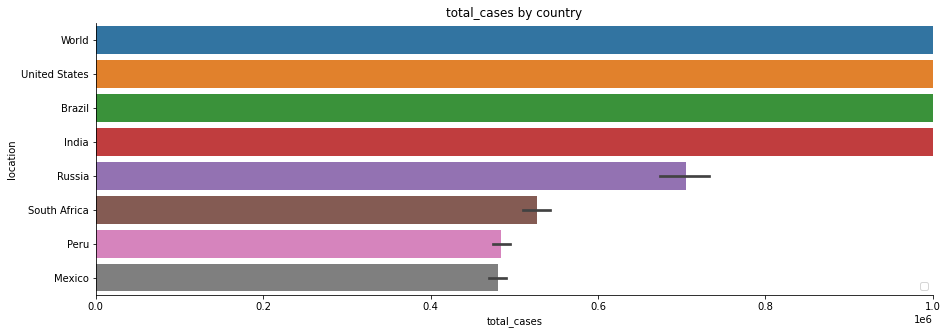

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


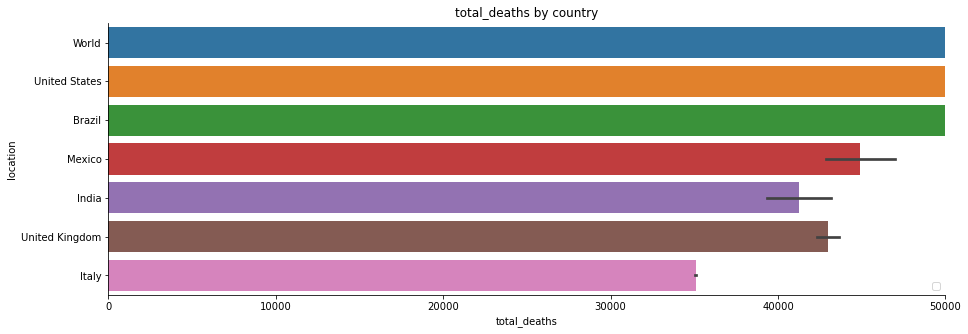

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


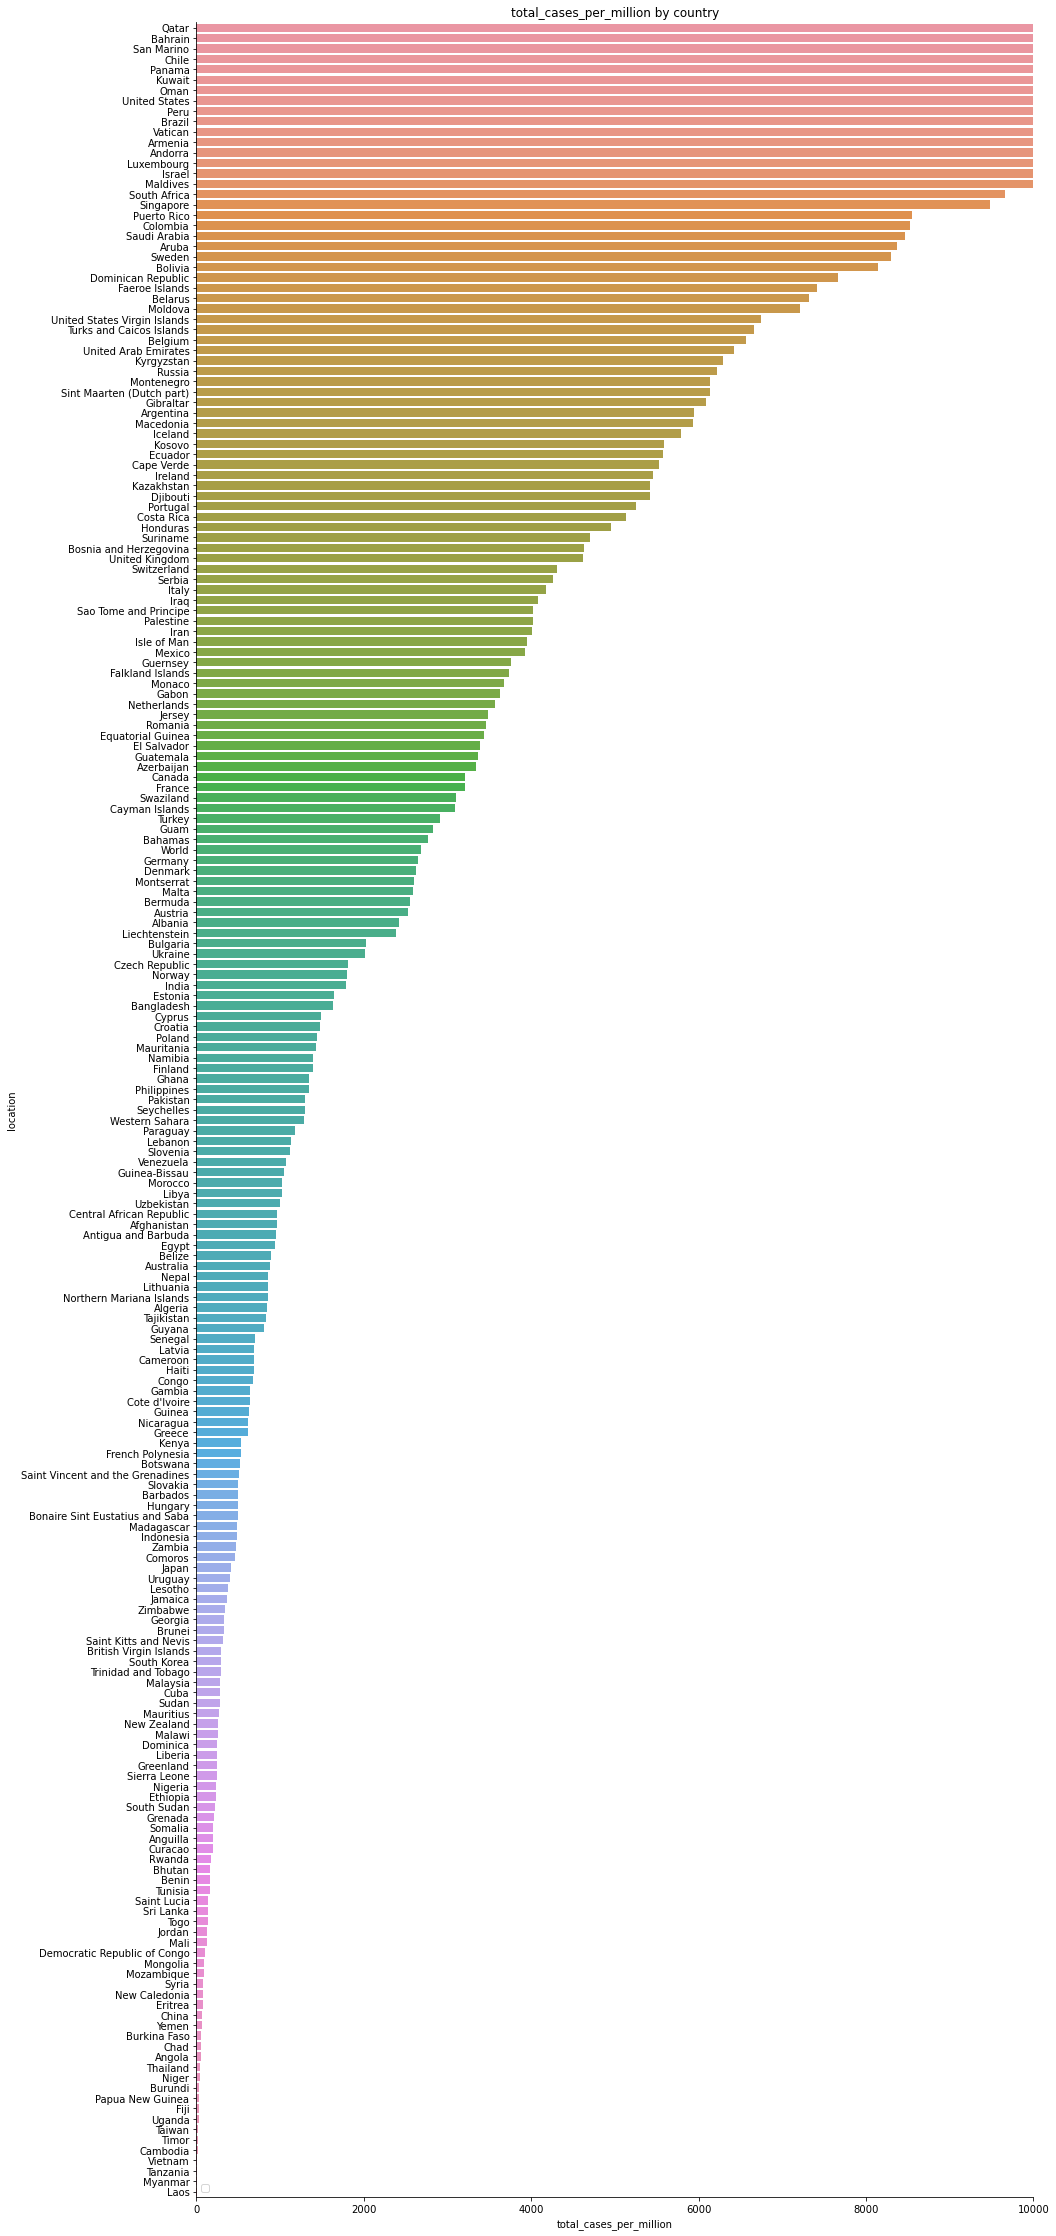

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


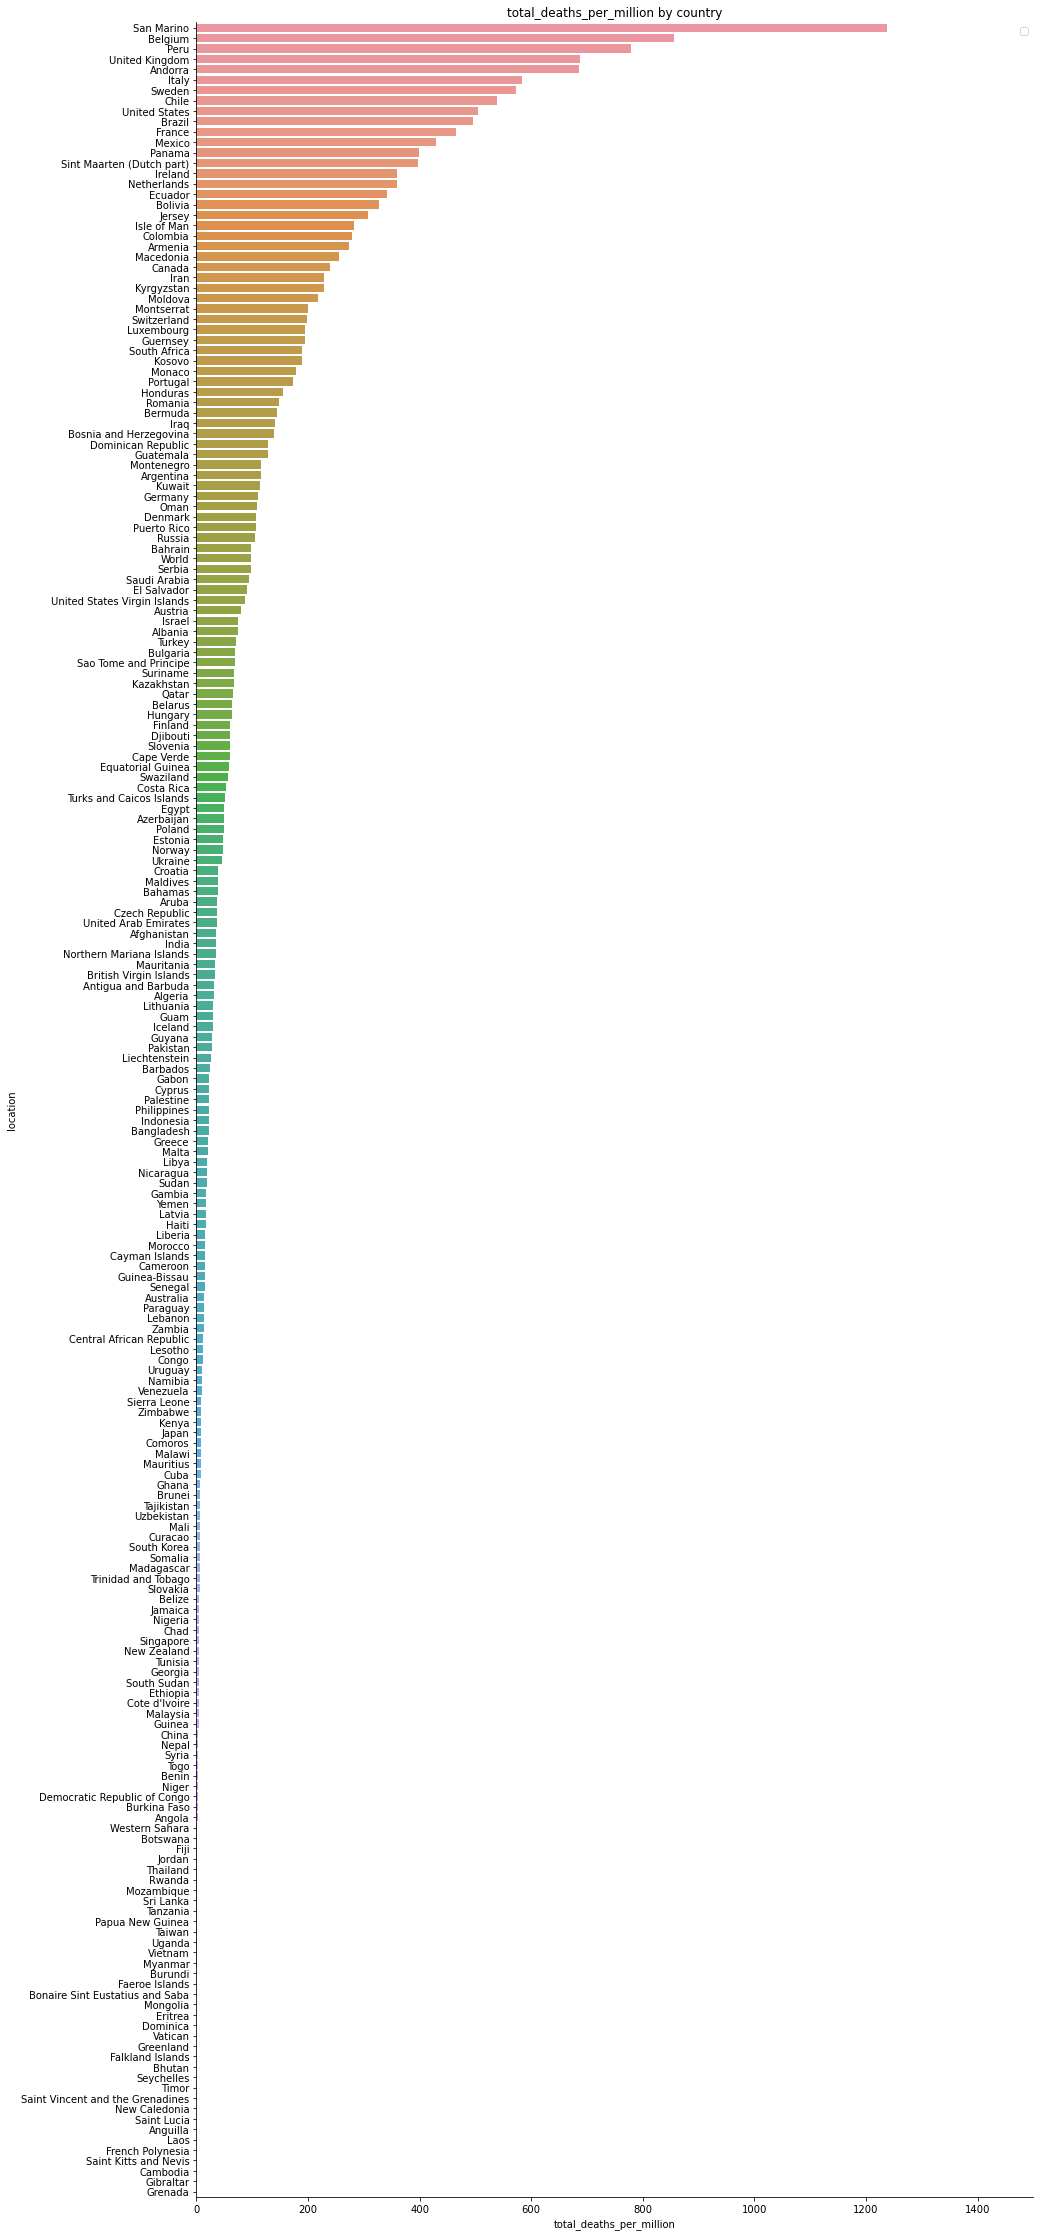

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

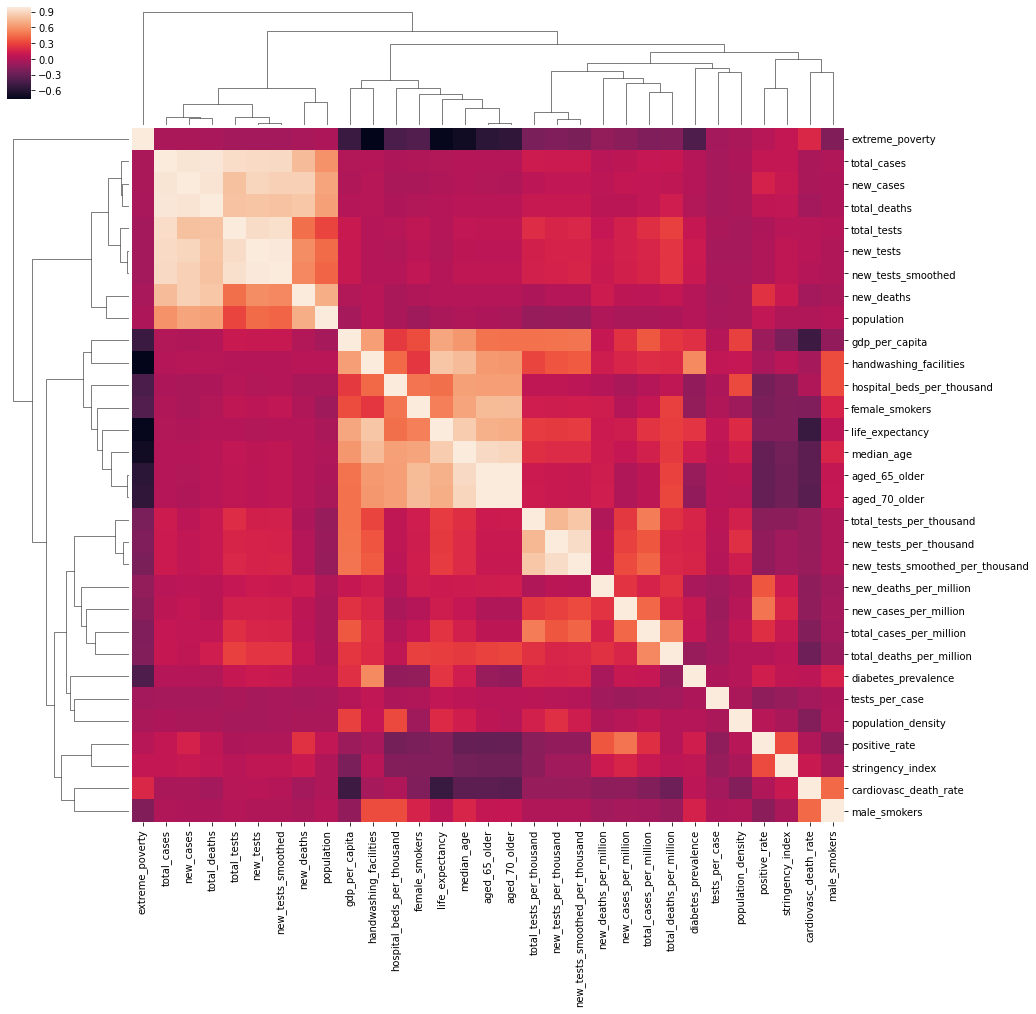

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996385621365631 (+/- 0.0002183551338006048)
Coef :  [1.04375894e+00 8.40605631e-05 8.83865825e-05]
3 Last_days :  [[20334678 20622170 20900777]]
Today :  20900777
Prediction + :  390840
Tomorow :  21291617
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995852003698972 (+/- 3.0039904765161525e-05)
Coef :  [-0.12314137  0.5475098   0.58540043]
3 Last_days :  [[742431 749479 759358]]
Today :  759358
Prediction + :  6108
Tomorow :  765466
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9881387676567304 (+/- 0.006473600863083541)
Coef :  [-0.67083376  0.73348846  0.93796858]
3 Last_days :  [[204172 206696 209365]]
Today :  209365
Prediction + :  1979
Tomorow :  211344
                                     
--------- Total Death -----------------
                                     
R^2: 0.4329305255209292 (+/- 0.7818543752688608)
Coef :  [-0.756185    0.78822105  0.96711827]
3 Last_days :  [[30354 30371 30388]]
Today :  30388
Prediction + :  37
Tomorow :  30425
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7310989564141367 (+/- 0.20080642896847736)
Coef :  [-0.32060816 -0.02711083  1.34199136]
3 Last_days :  [[88964 89045 89144]]
Today :  89144
Prediction + :  78
Tomorow :  89222
                                     
--------- Total Death -----------------
                                     
R^2: -1578.0681760360924 (+/- 2232.732693707264)
Coef :  [-0.07644547  0.01241084  1.05613229]
3 Last_days :  [[4693 4697 4700]]
Today :  4700
Prediction + :  7
Tomorow :  4707
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6303013648395447 (+/- 0.5208000091887296)
Coef :  [-0.83985172  0.9061023   0.93296342]
3 Last_days :  [[251237 251713 252235]]
Today :  252235
Prediction + :  531
Tomorow :  252766
                                     
--------- Total Death -----------------
                                     
R^2: 0.9604046127466571 (+/- 0.036784560173603605)
Coef :  [-0.83832938  0.90487767  0.93267632]
3 Last_days :  [[35215 35225 35231]]
Today :  35231
Prediction + :  31
Tomorow :  35262
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9830689592503509 (+/- 0.011965957470527486)
Coef :  [-0.74745278  0.78222344  0.96567211]
3 Last_days :  [[326612 329784 337334]]
Today :  337334
Prediction + :  2660
Tomorow :  339994
                                     
--------- Total Death -----------------
                                     
R^2: -2.342338683609824 (+/- 3.4199964180141937)
Coef :  [-0.71476686  0.60296268  1.11081858]
3 Last_days :  [[28581 28579 28605]]
Today :  28605
Prediction + :  10
Tomorow :  28615
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9958367268502641 (+/- 0.005324486625858671)
Coef :  [0.07650357 0.46818004 0.47604568]
3 Last_days :  [[5141207 5197148 5248242]]
Today :  5248242
Prediction + :  86617
Tomorow :  5334859
                                     
--------- Total Death -----------------
                                     
R^2: 0.5009219459124586 (+/- 0.7008411155221029)
Coef :  [-0.65791392  0.78017671  0.87982556]
3 Last_days :  [[164537 166027 167110]]
Today :  167110
Prediction + :  1424
Tomorow :  168534
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988327288293087 (+/- 0.0004071482101201901)
Coef :  [-0.78763431  0.8798231   0.90785664]
3 Last_days :  [[312789 313798 313798]]
Today :  313798
Prediction + :  1230
Tomorow :  315028
                                     
--------- Total Death -----------------
                                     
R^2: 0.4732314030203115 (+/- 0.7386915084457739)
Coef :  [-0.76192493  0.83013478  0.93169578]
3 Last_days :  [[46526 46706 46706]]
Today :  46706
Prediction + :  198
Tomorow :  46904
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9922155957305366 (+/- 0.009161582053417832)
Coef :  [-0.81725996  0.8685045   0.94832777]
3 Last_days :  [[218519 219964 221413]]
Today :  221413
Prediction + :  1298
Tomorow :  222711
                                     
--------- Total Death -----------------
                                     
R^2: 0.46196931707380234 (+/- 0.7443415352958214)
Coef :  [-0.79881353  0.84299237  0.95527181]
3 Last_days :  [[9207 9211 9225]]
Today :  9225
Prediction + :  10
Tomorow :  9235
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.3761304949798428 (+/- 0.8818492578032002)
Coef :  [0.13617382 0.4393135  0.43765641]
3 Last_days :  [[331189 333699 336324]]
Today :  336324
Prediction + :  3692
Tomorow :  340016
                                     
--------- Total Death -----------------
                                     
R^2: 0.9073662963816078 (+/- 0.13065164376672492)
Coef :  [-0.08768634  0.55451475  0.54715283]
3 Last_days :  [[18800 18988 19162]]
Today :  19162
Prediction + :  239
Tomorow :  19401
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984412158828216 (+/- 0.0019411483364059191)
Coef :  [-0.76660125  0.86155924  0.90220947]
3 Last_days :  [[243180 244392 245635]]
Today :  245635
Prediction + :  1067
Tomorow :  246702
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993801454606525 (+/- 0.0005434905892941687)
Coef :  [-0.82773216  0.90285247  0.92190008]
3 Last_days :  [[5873 5891 5912]]
Today :  5912
Prediction + :  16
Tomorow :  5928
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.47576432761122794 (+/- 0.7395150456921816)
Coef :  [-0.19291071  0.49121602  0.7210236 ]
3 Last_days :  [[3109630 3164785 3224876]]
Today :  3224876
Prediction + :  59320
Tomorow :  3284196
                                     
--------- Total Death -----------------
                                     
R^2: 0.5155687561182163 (+/- 0.680427201950994)
Coef :  [-0.2327299   0.56583649  0.6803151 ]
3 Last_days :  [[103026 104201 105463]]
Today :  105463
Prediction + :  1457
Tomorow :  106920
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(20900777, 759358, 21291617, 765466),
 (209365, 30388, 211344, 30425),
 (252235, 35231, 252766, 35262),
 (337334, 28605, 339994, 28615),
 (5248242, 167110, 5334859, 168534),
 (89144, 4700, 89222, 4707),
 (313798, 46706, 315028, 46904),
 (221413, 9225, 222711, 9235),
 (336324, 19162, 340016, 19401),
 (245635, 5912, 246702, 5928),
 (3224876, 105463, 3284196, 106920)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-14,France,211344.0,0.0,30425.0,0.0,0.0,0.0
0,2020-08-14,China,89222.0,0.0,4707.0,0.0,0.0,0.0
0,2020-08-14,Italy,252766.0,0.0,35262.0,0.0,0.0,0.0
0,2020-08-14,Spain,339994.0,0.0,28615.0,0.0,0.0,0.0
0,2020-08-14,United States,5334859.0,0.0,168534.0,0.0,0.0,0.0
0,2020-08-14,World,21291617.0,0.0,765466.0,0.0,0.0,0.0
0,2020-08-14,United Kingdom,315028.0,0.0,46904.0,0.0,0.0,0.0
0,2020-08-14,Germany,222711.0,0.0,9235.0,0.0,0.0,0.0
0,2020-08-14,Iran,340016.0,0.0,19401.0,0.0,0.0,0.0
0,2020-08-14,Turkey,246702.0,0.0,5928.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")